In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import Transformer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset

In [2]:
df = load_dataset("Helsinki-NLP/opus-100", "en-fr")

# See what you've loaded
print(df)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-fr/test-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

en-fr/validation-00000-of-00001.parquet:   0%|          | 0.00/334k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [3]:
# Sample 1% of the 'train' split for illustration
train_dataset = df['train']
total_rows = len(train_dataset)
sample_size = int(total_rows * 0.01)

# Shuffle the dataset with a seed for reproducibility and then select the desired number of samples
sampled_dataset = train_dataset.shuffle(seed=42).select(range(sample_size))

# Extract English and French sentences
# The 'translation' column contains a dictionary with 'en' and 'fr' keys
source_sentences = [item['en'] for item in sampled_dataset['translation']]
target_sentences = [item['fr'] for item in sampled_dataset['translation']]

# Check the sampled data size
print(f"Sampled data size: {len(sampled_dataset)}")

Sampled data size: 10000


In [4]:
# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

In [5]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [6]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 | Train Loss: 8.0091, Val Loss: 7.6214 | Train Acc: 0.0885, Val Acc: 0.1108


Epoch 2 | Train Loss: 7.0312, Val Loss: 7.3706 | Train Acc: 0.1231, Val Acc: 0.1309


Epoch 3 | Train Loss: 6.5441, Val Loss: 7.2198 | Train Acc: 0.1440, Val Acc: 0.1475


Epoch 4 | Train Loss: 6.1293, Val Loss: 7.1852 | Train Acc: 0.1619, Val Acc: 0.1569


Epoch 5 | Train Loss: 5.7414, Val Loss: 7.1764 | Train Acc: 0.1768, Val Acc: 0.1667


Epoch 6 | Train Loss: 5.3525, Val Loss: 7.2036 | Train Acc: 0.1937, Val Acc: 0.1770


Epoch 7 | Train Loss: 4.9629, Val Loss: 7.3124 | Train Acc: 0.2111, Val Acc: 0.1861


Epoch 8 | Train Loss: 4.5744, Val Loss: 7.4011 | Train Acc: 0.2319, Val Acc: 0.1945


Epoch 9 | Train Loss: 4.1934, Val Loss: 7.5618 | Train Acc: 0.2632, Val Acc: 0.2018


Epoch 10 | Train Loss: 3.8337, Val Loss: 7.7588 | Train Acc: 0.3044, Val Acc: 0.2057


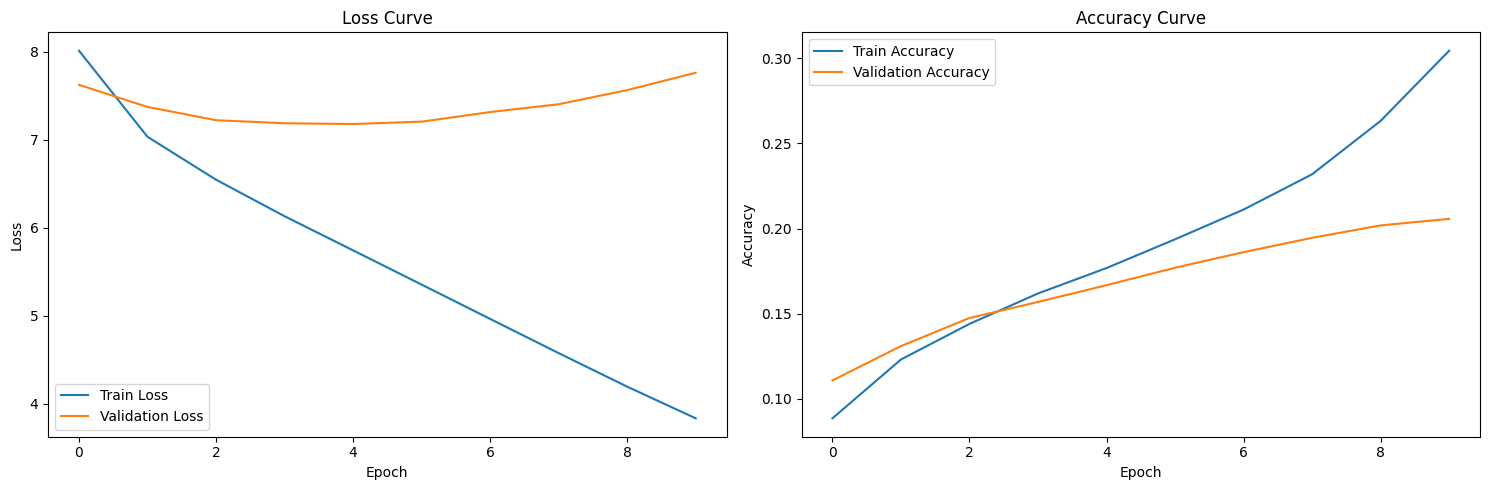

In [9]:
# === PLOTTING RESULTS ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#=== BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):  # Max translation length
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

In [11]:
# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000
